In [1]:
from Peak_Search_Linien import LinienDevice
from windfreak import SynthHD
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from linien_utils import get_waveform, set_scan_range
from linien_client.connection import LinienClient
from scipy.signal import find_peaks

import statistics
import time
import tqdm
import csv
resource_name_windfreak = "COM8"
synthd = SynthHD(resource_name_windfreak)
synthd.init()
rf_out = 0
c = LinienDevice(
    host="10.10.222.36",
    user="root",
    password="root"
)
# c.connect(autostart_server=True, use_parameter_cache=True)


linien_client.connection       INFO     Try to connect to 10.10.222.36:18862
linien_client.connection       INFO     Connection established!


Peak Search

In [8]:
zero_amp_all = []
fir_amp_all = []
pow_max_all = []
scan_data = []
power_scan = np.linspace(-10, 10, 30)
fre_scan = np.linspace(1900e6,2700e6,5)

fir_amps = []
synthd[rf_out].enable = False
c.ini_peak_search()
synthd[rf_out].enable = True

for rf_fre in fre_scan:
    zero_amp = []
    fir_amp = []
    sweep_center = []
    set_scan_range(c.client, 0, 0.8)     
    synthd[rf_out].frequency = rf_fre
    synthd[rf_out].power = -5
    time.sleep(1)
    c.mod_peak_search()
    c.zero_measure()
    c.sweep_center = 0
    c.fir_measure(rf_fre)
    for shdpower in tqdm.tqdm(power_scan):
        synthd[rf_out].power = shdpower
        c.fir_measure(rf_fre)        
        zero_amp.append(c.mod_zero_amp)
        fir_amp.append(c.fir_amp)
    pow_max = power_scan[fir_amp.index(max(fir_amp))]    
    scan_data.append([rf_fre,pow_max])
    fir_amps.append(fir_amp)
    pow_max_all.append(pow_max)
    zero_amp_all.append(zero_amp)
    fir_amp_all.append(fir_amp)
    

 93%|█████████▎| 28/30 [00:19<00:01,  1.41it/s]


KeyboardInterrupt: 

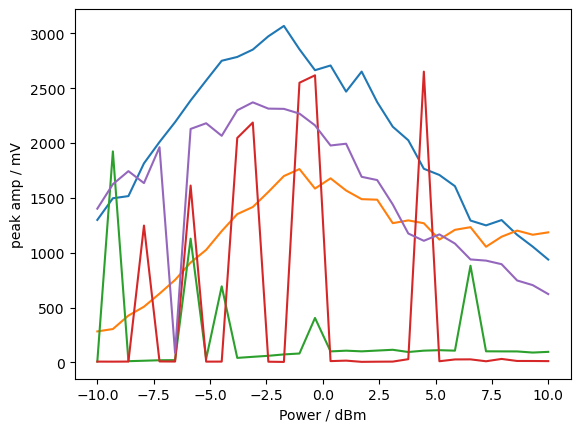

In [10]:

for i in range(5):
    plt.plot(power_scan,fir_amp_all[i],label = "first order")
    #plt.plot(power_scan,zero_amp_all[i],label = "zero order")
    plt.xlabel("Power / dBm")
    plt.ylabel("peak amp / mV")

In [3]:

import pickle
with open('2024_3_25_NLTL3_powerscan_5MHzstep_fir_amp_all.pickle', 'wb') as handle:
    pickle.dump(fir_amp_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('2024_3_25_NLTL3_powerscan_5MHzstep_zero_amp_all.pickle', 'wb') as handle:
    pickle.dump(zero_amp_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [ ]:
plt.plot(fre_scan,pow_max_all)

In [4]:
print(len(fir_amp_all))

200


IndexError: list index out of range

Text(0, 0.5, 'peak amp / mV')

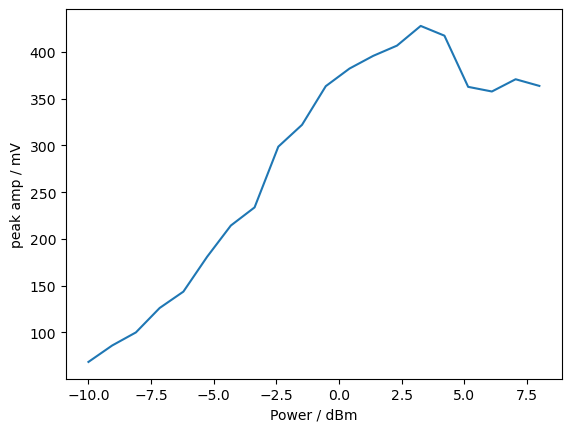

In [4]:
plt.plot(power_scan,fir_amp_all[0],label = "first order")
#plt.plot(power_scan,zero_amp_all[20],label = "zero order")
plt.xlabel("Power / dBm")
plt.ylabel("peak amp / mV")

In [ ]:
synthd.close()

[-0.20301619  0.18310253]


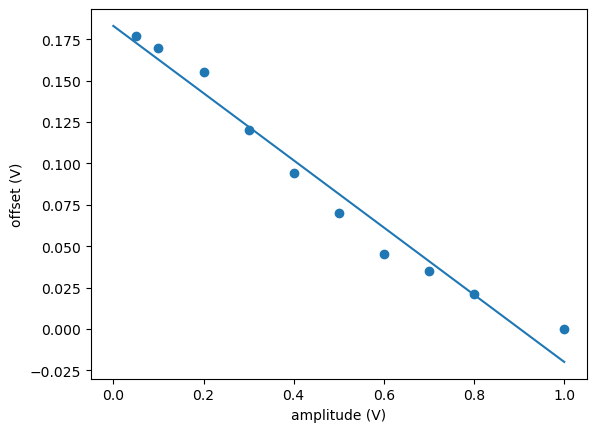

In [ ]:
x=[1,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
y=[0,0.021,0.035,0.045,0.07,0.094,0.12,0.155,0.17,0.177]
xs=np.linspace(0,1,100)
poly = np.polyfit(x,y,1)
poly_y = np.poly1d(poly)(xs)
plt.scatter(x,y)
plt.plot(xs,poly_y)
plt.xlabel("amplitude (V)")
plt.ylabel("offset (V)")
print(poly)

[-0.19236805  0.19767   ]


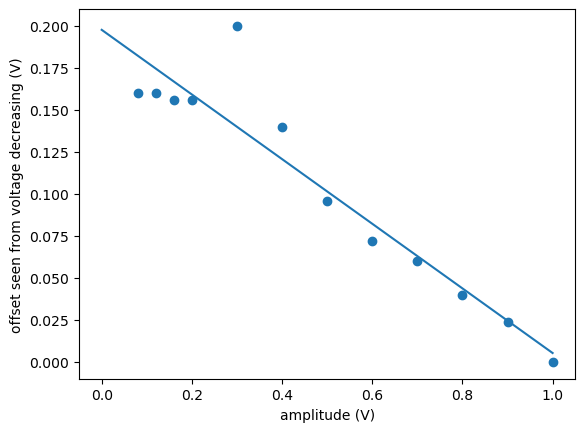

In [ ]:

x=np.array([2.5,2.25,2,  1.75, 1.5,1.25,   1,0.75,0.5,0.4,0.3,0.2])/2.5 # to convert to input before opamp
y=np.array([0,  0.06,0.1,0.15,0.18,0.24,0.35,0.5,0.39,0.39,0.4,0.4])/2.5
xs=np.linspace(0,1,100)
poly = np.polyfit(x,y,1)
poly_y = np.poly1d(poly)(xs)
plt.scatter(x,y)
plt.plot(xs,poly_y)
plt.xlabel("amplitude (V)")
plt.ylabel("offset seen from voltage decreasing (V)")
print(poly)

In [ ]:
x=[1,2,3,5,3,2,1]
print(np.argmax(x))

3
